In [1]:
#Import the required below:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import pi
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

In [2]:
# Set working directory
# Set the working directory to the path where your files are located
os.chdir('path_to_your_data')

In [3]:
# Load your existing data (replace 'survey_data.csv' with your file path)
df = pd.read_csv('your_data.csv', encoding='ISO-8859-1')


C:\Users\Brend\AppData\Local\Temp\ipykernel_16344\496177207.py:10: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


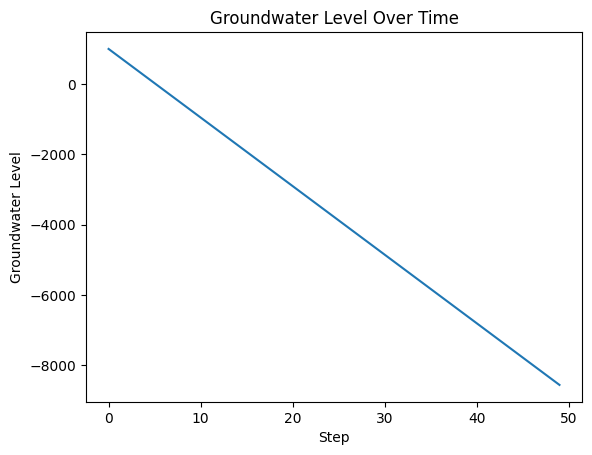

In [10]:
# Define decision options
#This defines the potential decisions available to each farmer agent. 
#Each option represents a specific action a farmer can take to address groundwater issues or maintain the status quo.

decision_options = [
    "Change irrigation system", "Irrigate less frequently", "Switch to dryland farming",
    "Turn off end guns", "Plant less water-intensive crops", "Stop farming", "Make no change"
]

# Define FarmerAgent class - This is the core representation of a farmer in the model.
# Initialization (__init__ method)
# Attributes:
# unique_id: A unique identifier for each agent.
# cluster: Farmer group type (e.g., Risk Averse, Socially Influenced).
# attitude, social_norms, PBC, moral_norms, perceived_risk, and climate_perc: Psychological and behavioral constructs from TPB.

class FarmerAgent(Agent):
    def __init__(self, unique_id, model, cluster, attitude, social_norms, PBC, moral_norms, perceived_risk, climate_perc):
        super().__init__(unique_id, model)
        self.cluster = cluster
        self.attitude = attitude
        self.social_norms = social_norms
        self.PBC = PBC
        self.moral_norms = moral_norms
        self.perceived_risk = perceived_risk
        self.climate_perc = climate_perc
        self.decision = None

# Behavior (step method)
# The decision-making process is implemented here:
# Cluster-specific logic:
# Each cluster (0 to 3) has unique weights applied to TPB constructs to compute decision scores.
# Example: In cluster == 0, attitude and PBC are weighted more heavily, while perceived risk reduces scores.

    
    def step(self):
        # Decision-making process based on TPB constructs and cluster
        if self.cluster == 0:
            decision_scores = [
                self.attitude * 0.4 + self.PBC * 0.3 - self.perceived_risk * 0.2,
                self.attitude * 0.3 + self.moral_norms * 0.2 - self.perceived_risk * 0.1,
                self.PBC * 0.5 - self.climate_perc * 0.1,
                self.social_norms * 0.4 + self.moral_norms * 0.2,
                self.moral_norms * 0.5 - self.perceived_risk * 0.2,
                self.perceived_risk * 0.6 - self.PBC * 0.2,
                0  # Make no change
            ]
        elif self.cluster == 1:
            decision_scores = [
                self.attitude * 0.3 + self.moral_norms * 0.3 - self.perceived_risk * 0.2,
                self.PBC * 0.4 - self.attitude * 0.1,
                self.moral_norms * 0.5 + self.social_norms * 0.2,
                self.climate_perc * 0.3 + self.attitude * 0.1,
                self.moral_norms * 0.4 - self.perceived_risk * 0.1,
                self.perceived_risk * 0.5 - self.PBC * 0.1,
                0
            ]
        elif self.cluster == 2:
            decision_scores = [
                self.PBC * 0.4 + self.attitude * 0.2 - self.perceived_risk * 0.1,
                self.social_norms * 0.3 + self.moral_norms * 0.3,
                self.climate_perc * 0.5 - self.attitude * 0.1,
                self.moral_norms * 0.4 + self.PBC * 0.2,
                self.perceived_risk * 0.5 - self.moral_norms * 0.2,
                self.attitude * 0.2 + self.climate_perc * 0.3,
                0
            ]
        else:  # Cluster 3
            decision_scores = [
                self.moral_norms * 0.4 + self.social_norms * 0.3,
                self.attitude * 0.3 + self.perceived_risk * 0.2,
                self.climate_perc * 0.4 - self.PBC * 0.2,
                self.PBC * 0.3 + self.moral_norms * 0.1,
                self.attitude * 0.4 - self.perceived_risk * 0.1,
                self.perceived_risk * 0.6 - self.attitude * 0.2,
                0
            ]

        # Decisionn selection - The action with the highest score is selected as the farmer's decision.
        # Choose the action with the highest score
        max_score = max(decision_scores)
        self.decision = decision_options[decision_scores.index(max_score)]

# Define FarmerModel class
# This represents the overall simulation model, which includes farmers as agents and a shared groundwater resource.
# Initialization (__init__ method)
# Attributes:
    # num_agents: Total number of agents, derived from the input dataset (df).
    # schedule: A RandomActivation scheduler to ensure agents act in random order each step.
    # groundwater_level: Initial groundwater level (set to 1000 units).

class FarmerModel(Model):
    def __init__(self, df):
        self.num_agents = len(df)
        self.schedule = RandomActivation(self)
        self.groundwater_level = 1000  # Initial groundwater level

        # Create agents based on the survey data - Each row in the input dataframe (df) initializes a farmer agent with its cluster and TPB attributes.
        for i, row in df.iterrows():
            agent = FarmerAgent(
                unique_id=i,
                model=self,
                cluster=row['cluster'],
                attitude=row['Attitude'],
                social_norms=row['Social_Norms'],
                PBC=row['PBC'],
                moral_norms=row['Moral_Norms'],
                perceived_risk=row['Perceived_Risk'],
                climate_perc=row['Climate_Perc']
            )
            self.schedule.add(agent)

        # Data collector for tracking decisions and groundwater level - Tracks the groundwater level at each step.
        self.datacollector = DataCollector(
            model_reporters={"Groundwater Level": lambda m: m.groundwater_level}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

        # Reduce groundwater level based on agent decisions
        # Collects data and updates agent decisions for the current step.
        # Reduces groundwater levels by 5 units for every farmer decision other than "Make no change".

        for agent in self.schedule.agents:
            if agent.decision != "Make no change":
                self.groundwater_level -= 5  # Example impact of irrigation

# Run the model
model = FarmerModel(df)

# Simulate for 50 steps
for i in range(50):
    model.step()

# Analyze results
results = model.datacollector.get_model_vars_dataframe()
plt.plot(results['Groundwater Level'])
plt.title("Groundwater Level Over Time")
plt.xlabel("Step")
plt.ylabel("Groundwater Level")
plt.show()


**EXAMPLE TWO:**

Let us now follow the same steps but use the clusters we derived from our previous analysis

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import pandas as pd

# Load your data
data = pd.read_csv("path/to/your/data.csv")

In [ ]:


# Define the FarmerAgent class
class FarmerAgent(Agent):
    def __init__(self, unique_id, model, cluster_type, age, income, irrigation_method, water_source, future_plans):
        super().__init__(unique_id, model)
        self.cluster_type = cluster_type
        self.age = age
        self.income = income
        self.irrigation_method = irrigation_method
        self.water_source = water_source
        self.future_plans = future_plans
        self.irrigation_decision = 0  # Initialize irrigation decision

    def step(self):
        # Decision-making based on cluster type and water source
        if self.cluster_type == "Innovative":
            self.irrigation_decision = self.make_innovative_decision()
        elif self.cluster_type == "Risk-Averse":
            self.irrigation_decision = self.make_risk_averse_decision()
        elif self.cluster_type == "Socially Influenced":
            self.irrigation_decision = self.make_social_decision()
        elif self.cluster_type == "Traditional":
            self.irrigation_decision = self.make_traditional_decision()

    def make_innovative_decision(self):
        # Innovative adopters are more likely to invest in irrigation
        if self.water_source in [1, 4]:  # GROUNDWATER or SURFACE AND GROUND
            return random.randint(10, 15)
        elif self.water_source == 2:  # SURFACE
            return random.randint(5, 10)
        elif self.water_source == 3:  # DRYLAND
            return random.randint(0, 3)
        return random.randint(3, 8)

    def make_risk_averse_decision(self):
        # Risk-averse adopters prefer conservative irrigation based on water source
        if self.water_source in [1, 4]:
            return random.randint(5, 10)
        elif self.water_source == 2:
            return random.randint(3, 7)
        elif self.water_source == 3:
            return random.randint(0, 2)
        return random.randint(2, 6)

    def make_social_decision(self):
        # Socially influenced decisions consider water source and social norms
        if self.water_source in [1, 4]:
            return random.randint(7, 12)
        elif self.water_source == 2:
            return random.randint(5, 10)
        return random.randint(3, 7)

    def make_traditional_decision(self):
        # Traditionalists use minimal irrigation, influenced heavily by water source
        if self.water_source == 1:
            return random.randint(5, 8)
        elif self.water_source == 2:
            return random.randint(3, 5)
        elif self.water_source == 3:
            return random.randint(0, 2)
        return random.randint(2, 5)

# Define the FarmerModel class
class FarmerModel(Model):
    def __init__(self, data):
        self.num_agents = len(data)
        self.schedule = RandomActivation(self)

        # Create agents based on the data
        for i, row in data.iterrows():
            cluster_type = row['cluster']  # Replace with actual cluster labels
            age = row['Age']
            income = row['Annual farm income']
            irrigation_method = row['Irrigation Method Coded']
            water_source = row['Water Source Coded']
            future_plans = row['Future plans Coded']

            agent = FarmerAgent(i, self, cluster_type, age, income, irrigation_method, water_source, future_plans)
            self.schedule.add(agent)

    def step(self):
        self.schedule.step()

# Load the clustered data (ensure you have cluster labels in your data)
data['cluster'] = data2['cluster']  # Add cluster assignments if not already done

# Initialize and run the model
model = FarmerModel(data)

for i in range(10):  # Run the model for 10 steps
    model.step()

print("Model simulation complete.")
